# Estimate Home Tax Values in Zillow
Authors: Matthew Mays, Gilbert Noriega

## Goals
- Our goal for this project is to create a model that will predict the values of single unit properties that the tax district assesses using the property data from those whose last transaction was during the months of May and June in 2017.

## Import Modules:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from acquire import get_zillow_data
from prepare import prep_zillow_final, zillow_split, add_scaled_columns
from model import plot_variable_pairs
from model import select_kbest, rfe
from model import linearReg_train, lassoLars_train, poly_linearReg_train
from model import linearReg_validate, lassoLars_validate, poly_linearReg_validate

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")

## Data Acquire

- Our function, **get_zillow_data**, uses the SQL query we created to bring in data from the Zillow database to include only single unit residential properties whose last transactions were in the months of May and June in 2017. We joined a table to get the last transaction which gave us a total row count of 15,036.



## Data Prep

In [2]:
df = get_zillow_data()

In [3]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,parcelid.1,logerror,transactiondate
0,2061546,11289917,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,11289917,-0.362001,2017-06-23
1,1834372,11705026,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,11705026,-0.146056,2017-06-30
2,1923117,14269464,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,...,2016.0,445569.0,9819.72,NaN,NaN,6.059064e+13,2028,14269464,0.021085,2017-06-01
3,2121349,11389003,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,2016.0,449000.0,7673.19,NaN,NaN,6.037703e+13,3273,11389003,-0.325393,2017-06-01
4,2093710,11967869,NaN,NaN,NaN,1.0,2.0,NaN,5.0,1.0,...,2016.0,191821.0,3267.47,NaN,NaN,6.037185e+13,3429,11967869,-0.005566,2017-06-29


<div class="alert alert-block alert-info">There are a lot of null values and with 63 columns we needed to trim some of this down.</div>

In [4]:
df.describe()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id.1,parcelid.1,logerror
count,1.503600e+04,1.503600e+04,3982.000000,15.000000,11.000000,15036.000000,15036.000000,0.0,9572.000000,14990.000000,...,1.501000e+04,1.503600e+04,15036.0,1.503600e+04,15035.000000,527.000000,1.499000e+04,15036.000000,1.503600e+04,15036.000000
mean,1.516020e+06,1.303819e+07,2.454043,7.600000,761.454545,2.322426,3.307595,NaN,6.303385,2.328686,...,2.017709e+05,5.434477e+05,2016.0,3.420257e+05,6618.896851,14.053131,6.049682e+13,42505.745611,1.303819e+07,0.014378
std,8.597327e+05,3.927138e+06,3.858626,3.924283,444.816673,1.025202,0.951095,NaN,1.718302,1.019673,...,2.633235e+05,7.354153e+05,0.0,5.287097e+05,8513.788079,1.496836,2.104661e+11,6477.676206,3.927138e+06,0.177396
min,3.490000e+02,1.071210e+07,1.000000,2.000000,280.000000,0.000000,0.000000,NaN,1.000000,1.000000,...,1.290000e+02,1.050400e+04,2016.0,2.250000e+03,51.260000,8.000000,6.037101e+13,1248.000000,1.071210e+07,-4.453964
25%,7.786892e+05,1.150329e+07,1.000000,7.000000,497.000000,2.000000,3.000000,NaN,5.000000,2.000000,...,7.910075e+04,1.986335e+05,2016.0,7.964625e+04,2707.960000,14.000000,6.037401e+13,37033.250000,1.150329e+07,-0.026889
50%,1.537406e+06,1.258458e+07,1.000000,7.000000,640.000000,2.000000,3.000000,NaN,6.000000,2.000000,...,1.356615e+05,3.851740e+05,2016.0,2.247385e+05,4775.900000,15.000000,6.037621e+13,42558.500000,1.258458e+07,0.004645
75%,2.260508e+06,1.414342e+07,1.000000,7.000000,865.500000,3.000000,4.000000,NaN,8.000000,3.000000,...,2.349185e+05,6.452412e+05,2016.0,4.235195e+05,7683.940000,15.000000,6.059042e+13,48039.750000,1.414342e+07,0.037333
max,2.982270e+06,1.676878e+08,13.000000,21.000000,1809.000000,11.000000,12.000000,NaN,12.000000,11.000000,...,7.893568e+06,2.385837e+07,2016.0,1.635060e+07,276797.830000,15.000000,6.111009e+13,53501.000000,1.676878e+08,3.175688


<div class="alert alert-block alert-info">Takeaways:

- There are many columns with missing values.

- There are repeat duplicate columns.

- Some numerical columns are categorical.</div>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15036 entries, 0 to 15035
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            15036 non-null  int64  
 1   parcelid                      15036 non-null  int64  
 2   airconditioningtypeid         3982 non-null   float64
 3   architecturalstyletypeid      15 non-null     float64
 4   basementsqft                  11 non-null     float64
 5   bathroomcnt                   15036 non-null  float64
 6   bedroomcnt                    15036 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         9572 non-null   float64
 9   calculatedbathnbr             14990 non-null  float64
 10  decktypeid                    107 non-null    float64
 11  finishedfloor1squarefeet      1295 non-null   float64
 12  calculatedfinishedsquarefeet  15012 non-null  float64
 13  f

### Columns to drop based on nulls:
- airconditioningtypeid
- architecturalstyletypeid
- basementsqft
- buildingclasstypeid
- decktypeid 
- finishedfloor1squarefeet
- finishedsquarefeetX (5 columns)
- fireplacecnt
- hashottuborspa
- poolsizesum
- pooltypeidX (3 columns)
- storytypeid
- threequarterbathnbr
- typeconstructiontypeid
- yardbuildingsqftX (2 columns)
- fireplaceflag
- taxdelinquencyflag
- taxdelinquincyyear
- numberofstories
- heatingorsystemtypeid
- garagecarcnt
- garagetotalsqft

### Columns to drop based on relevance
**ParcelId/Id:**
- Will not need in the model.

**Buildingqualitytypeid:**
- No information on building quality type id.

**Calculatedbathnbr:**
- Seems to just be the bathroom count.

**latitude & longitude:**
- Not relevant to property value when we have county information.

**Propertylandusetypeid:**
- All 261 because we are only looking at single family residential properties.

**Rawcensustractandblock:**
- Seems to be population of some sort which has little relevance to our target.

**Regionidcity, regionidcounty, regionidneighborhood, regionidzip:**
- Will be using fips which provides county information which we will be using for location data.

**Unitcnt:**
- Should all be 1 due to these being 1 unit properties.

**structure/landtaxvaluedollarcnt:**
- We are looking for tax value of the property not the structure itself.

**assessmentyear:**
- These are all for 2017 so the assessments are all 2016.

**taxamount:**
- Tax amount uses data we haven't looked at yet and is dependent on our target variable.

**censustractandblock:**
- Doesn't seem to be relevant to property value.

**transactiondate:**
- We already know that these are between the months of may and june, the individual day doesn't matter.

**propertyzoningdesc:**
- categorical with many different variables that doesn't seem too relevant to our target.

**propertycountylandusecode:**
- categorical of what type of property should be on that land.

In [6]:
columns_to_drop = ['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid',
                  'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13',
                  'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt',
                  'hashottuborspa', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'storytypeid',
                  'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26',
                  'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear', 'id', 'buildingqualitytypeid',
                  'calculatedbathnbr', 'latitude', 'longitude', 'propertylandusetypeid', 'rawcensustractandblock',
                  'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'unitcnt',
                  'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'assessmentyear', 'taxamount',
                  'censustractandblock', 'transactiondate', 'propertyzoningdesc', 'logerror', 'parcelid',
                  'numberofstories', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'propertycountylandusecode',
                  'id.1', 'parcelid.1']

In [7]:
df = df.drop(columns=columns_to_drop)
df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,lotsizesquarefeet,poolcnt,roomcnt,yearbuilt,taxvaluedollarcnt
0,2.0,3.0,1458.0,6037.0,2.0,8284.0,1.0,0.0,1970.0,136104.0
1,1.0,2.0,1421.0,6037.0,1.0,6707.0,NaN,0.0,1911.0,35606.0
2,3.0,4.0,2541.0,6059.0,3.0,4975.0,NaN,0.0,2003.0,880456.0
3,2.0,3.0,1650.0,6037.0,2.0,7300.0,NaN,0.0,1949.0,614000.0
4,1.0,2.0,693.0,6037.0,1.0,2908.0,NaN,0.0,1921.0,274237.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15036 entries, 0 to 15035
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   15036 non-null  float64
 1   bedroomcnt                    15036 non-null  float64
 2   calculatedfinishedsquarefeet  15012 non-null  float64
 3   fips                          15036 non-null  float64
 4   fullbathcnt                   14990 non-null  float64
 5   lotsizesquarefeet             14932 non-null  float64
 6   poolcnt                       3290 non-null   float64
 7   roomcnt                       15036 non-null  float64
 8   yearbuilt                     14995 non-null  float64
 9   taxvaluedollarcnt             15036 non-null  float64
dtypes: float64(10)
memory usage: 1.3 MB


<div class="alert alert-block alert-info">There are still some columns with null values, but first we will be changing the names of some columns to be more readable.</div>

In [9]:
df = df.rename(columns={'bathroomcnt': 'bathroom', 'bedroomcnt': 'bedroom', 'calculatedfinishedsquarefeet': 'sqft',
                        'taxvaluedollarcnt': 'propertytaxvalue', 'lotsizesquarefeet': 'lotsqft'})

In [10]:
df.head()

,bathroom,bedroom,sqft,fips,fullbathcnt,lotsqft,poolcnt,roomcnt,yearbuilt,propertytaxvalue
0,2.0,3.0,1458.0,6037.0,2.0,8284.0,1.0,0.0,1970.0,136104.0
1,1.0,2.0,1421.0,6037.0,1.0,6707.0,NaN,0.0,1911.0,35606.0
2,3.0,4.0,2541.0,6059.0,3.0,4975.0,NaN,0.0,2003.0,880456.0
3,2.0,3.0,1650.0,6037.0,2.0,7300.0,NaN,0.0,1949.0,614000.0
4,1.0,2.0,693.0,6037.0,1.0,2908.0,NaN,0.0,1921.0,274237.0


In [11]:
df.describe()

,bathroom,bedroom,sqft,fips,fullbathcnt,lotsqft,poolcnt,roomcnt,yearbuilt,propertytaxvalue
count,15036.000000,15036.000000,15012.000000,15036.000000,14990.000000,1.493200e+04,3290.0,15036.000000,14995.000000,1.503600e+04
mean,2.322426,3.307595,1942.043165,6049.395318,2.260841,1.062587e+04,1.0,1.909284,1963.853084,5.434477e+05
std,1.025202,0.951095,1001.672378,21.237001,0.994149,3.028759e+04,0.0,3.162112,23.329705,7.354153e+05
min,0.000000,0.000000,300.000000,6037.000000,1.000000,5.940000e+02,1.0,0.000000,1878.000000,1.050400e+04
25%,2.000000,3.000000,1274.750000,6037.000000,2.000000,5.597000e+03,1.0,0.000000,1950.000000,1.986335e+05
50%,2.000000,3.000000,1679.000000,6037.000000,2.000000,6.876500e+03,1.0,0.000000,1961.000000,3.851740e+05
75%,3.000000,4.000000,2346.000000,6059.000000,3.000000,8.888000e+03,1.0,5.000000,1980.000000,6.452412e+05
max,11.000000,12.000000,15450.000000,6111.000000,11.000000,1.323788e+06,1.0,14.000000,2015.000000,2.385837e+07


<div class="alert alert-block alert-info">The pool count column has a lot of null values but a minimum of 1. We decided to replace null values with zeros.</div>

In [12]:
df['poolcnt'] = df.poolcnt.fillna(0)

In [13]:
df.head()

,bathroom,bedroom,sqft,fips,fullbathcnt,lotsqft,poolcnt,roomcnt,yearbuilt,propertytaxvalue
0,2.0,3.0,1458.0,6037.0,2.0,8284.0,1.0,0.0,1970.0,136104.0
1,1.0,2.0,1421.0,6037.0,1.0,6707.0,0.0,0.0,1911.0,35606.0
2,3.0,4.0,2541.0,6059.0,3.0,4975.0,0.0,0.0,2003.0,880456.0
3,2.0,3.0,1650.0,6037.0,2.0,7300.0,0.0,0.0,1949.0,614000.0
4,1.0,2.0,693.0,6037.0,1.0,2908.0,0.0,0.0,1921.0,274237.0


<div class="alert alert-block alert-info">There are properties that have a zero in the room count while having bathroom and bedroom counts. Rather than remove zeros we decided to replace any zeros with the sum of the bathroom and bedroom count.</div>

In [14]:
df['roomcnt'] = np.where(df['roomcnt'] == 0.0, (df.bathroom + df.bedroom), df['roomcnt'])

In [15]:
df.head()

,bathroom,bedroom,sqft,fips,fullbathcnt,lotsqft,poolcnt,roomcnt,yearbuilt,propertytaxvalue
0,2.0,3.0,1458.0,6037.0,2.0,8284.0,1.0,5.0,1970.0,136104.0
1,1.0,2.0,1421.0,6037.0,1.0,6707.0,0.0,3.0,1911.0,35606.0
2,3.0,4.0,2541.0,6059.0,3.0,4975.0,0.0,7.0,2003.0,880456.0
3,2.0,3.0,1650.0,6037.0,2.0,7300.0,0.0,5.0,1949.0,614000.0
4,1.0,2.0,693.0,6037.0,1.0,2908.0,0.0,3.0,1921.0,274237.0


In [16]:
df[df['fullbathcnt'].isnull()]

,bathroom,bedroom,sqft,fips,fullbathcnt,lotsqft,poolcnt,roomcnt,yearbuilt,propertytaxvalue
5,0.0,0.0,1378.0,6037.0,NaN,7500.0,0.0,0.0,NaN,168828.0
111,2.5,3.0,904.0,6059.0,NaN,18719.0,1.0,7.0,1948.0,162456.0
209,0.0,0.0,2276.0,6037.0,NaN,10772.0,0.0,0.0,NaN,101792.0
280,0.0,0.0,NaN,6059.0,NaN,105970.0,0.0,0.0,NaN,2493444.0
293,0.0,0.0,400.0,6037.0,NaN,55016.0,0.0,0.0,1950.0,49627.0
746,0.0,0.0,389.0,6037.0,NaN,7681.0,0.0,0.0,NaN,319396.0
920,0.0,0.0,NaN,6059.0,NaN,13329.0,0.0,0.0,NaN,270009.0
921,0.0,0.0,NaN,6059.0,NaN,20457.0,0.0,0.0,NaN,7074075.0
940,0.0,0.0,NaN,6037.0,NaN,30346.0,0.0,0.0,NaN,5461875.0
1741,0.0,0.0,4184.0,6059.0,NaN,96141.0,0.0,0.0,1964.0,1145602.0


<div class="alert alert-block alert-info">Because there are only 46 rows where fullbathcnt is null, and these all have their own problems with incomplete data we will be dropping rows where fullbathcnt is null.</div>

In [17]:
df = df[~df['fullbathcnt'].isna()]
print(f"There are now {df['fullbathcnt'].isna().sum()} null values in the fullbathcnt column.")

There are now 0 null values in the fullbathcnt column.


<div class="alert alert-block alert-info">While this fixed our issues with fullbathcnt there are still values of zero for bedroom and bathroom count, however there aren't many.</div>

In [18]:
print(f"Total values of zero: {(df['bedroom'] == 0).sum() + (df['bathroom'] == 0).sum()}")

Total values of zero: 6


In [19]:
df = df[df['bedroom'] != 0]

In [20]:
df.shape

(14984, 10)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14984 entries, 0 to 15035
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bathroom          14984 non-null  float64
 1   bedroom           14984 non-null  float64
 2   sqft              14984 non-null  float64
 3   fips              14984 non-null  float64
 4   fullbathcnt       14984 non-null  float64
 5   lotsqft           14887 non-null  float64
 6   poolcnt           14984 non-null  float64
 7   roomcnt           14984 non-null  float64
 8   yearbuilt         14968 non-null  float64
 9   propertytaxvalue  14984 non-null  float64
dtypes: float64(10)
memory usage: 1.3 MB


<div class="alert alert-block alert-info">There are still a few missing values to clean up.</div>

In [22]:
df[df['lotsqft'].isnull()]

,bathroom,bedroom,sqft,fips,fullbathcnt,lotsqft,poolcnt,roomcnt,yearbuilt,propertytaxvalue
340,1.0,1.0,504.0,6059.0,1.0,NaN,0.0,4.0,1964.0,92355.0
476,1.0,2.0,768.0,6037.0,1.0,NaN,0.0,3.0,1926.0,152289.0
634,6.0,5.0,4985.0,6037.0,6.0,NaN,0.0,11.0,2010.0,1430519.0
713,1.0,2.0,1220.0,6037.0,1.0,NaN,0.0,3.0,1910.0,572459.0
751,2.0,3.0,1202.0,6037.0,2.0,NaN,0.0,5.0,1958.0,593000.0
...,...,...,...,...,...,...,...,...,...,...
14650,3.0,3.0,1511.0,6037.0,3.0,NaN,0.0,6.0,2014.0,364982.0
14679,3.0,3.0,3286.0,6037.0,3.0,NaN,0.0,6.0,2014.0,675141.0
14827,4.0,4.0,4351.0,6037.0,4.0,NaN,0.0,8.0,2015.0,760745.0
14831,3.0,4.0,2192.0,6037.0,3.0,NaN,0.0,7.0,2013.0,488252.0


<div class="alert alert-block alert-info">There are 97 rows with a null value in this column. Because it is so few compared to the total data set and there isn't an easy way to estimate the lot square footage we decided to drop these rows.</div>

In [23]:
df = df[~df['lotsqft'].isna()]

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14887 entries, 0 to 15035
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bathroom          14887 non-null  float64
 1   bedroom           14887 non-null  float64
 2   sqft              14887 non-null  float64
 3   fips              14887 non-null  float64
 4   fullbathcnt       14887 non-null  float64
 5   lotsqft           14887 non-null  float64
 6   poolcnt           14887 non-null  float64
 7   roomcnt           14887 non-null  float64
 8   yearbuilt         14871 non-null  float64
 9   propertytaxvalue  14887 non-null  float64
dtypes: float64(10)
memory usage: 1.2 MB


In [25]:
df[df['yearbuilt'].isnull()]

,bathroom,bedroom,sqft,fips,fullbathcnt,lotsqft,poolcnt,roomcnt,yearbuilt,propertytaxvalue
3991,1.0,2.0,736.0,6037.0,1.0,3709.0,0.0,3.0,NaN,21283.0
4490,3.0,3.0,1310.0,6037.0,3.0,5458.0,0.0,6.0,NaN,319000.0
4981,3.0,5.0,3800.0,6111.0,3.0,48787.0,1.0,11.0,NaN,605142.0
5756,4.5,6.0,4103.0,6111.0,4.0,15888.0,1.0,11.0,NaN,939970.0
7004,2.0,3.0,1163.0,6111.0,2.0,4074.0,0.0,5.0,NaN,317286.0
7051,2.5,3.0,2764.0,6111.0,2.0,15492.0,1.0,6.0,NaN,549573.0
7386,2.5,3.0,2516.0,6111.0,2.0,20000.0,1.0,7.0,NaN,204638.0
8563,3.5,4.0,3574.0,6111.0,3.0,9630.0,0.0,6.0,NaN,582991.0
8800,3.0,3.0,1964.0,6037.0,3.0,4298.0,0.0,6.0,NaN,573616.0
8852,1.0,1.0,711.0,6111.0,1.0,3600.0,0.0,3.0,NaN,108709.0


<div class="alert alert-block alert-info">Similar to the last feature we will be dropping these 16 rows for the same reasons as above.</div>

In [26]:
df = df[~df['yearbuilt'].isna()]
df.shape

(14871, 10)

<div class="alert alert-block alert-info">After dropping features and taking care of nulls we are left with 14,871 rows and 10 columns of data. Now we will split the data and scale it.</div>

In [27]:
df = prep_zillow_final()
train, validate, test = zillow_split(df)

In [28]:
# These are the columns we will be scaling.
columns_to_scale = ['bathroom', 'bedroom', 'sqft', 'lotsqft', 'fullbathcnt', 'roomcnt']

In [29]:
train, validate, test = add_scaled_columns(train, validate, test, columns_to_scale)

In [30]:
train.head()

,bathroom,bedroom,sqft,fips,fullbathcnt,lotsqft,poolcnt,roomcnt,yearbuilt,propertytaxvalue,bathroom_scaled,bedroom_scaled,sqft_scaled,lotsqft_scaled,fullbathcnt_scaled,roomcnt_scaled
12272,1.0,2.0,1060.0,6037.0,1.0,4795.0,0.0,3.0,1935.0,196289.0,0.0000,0.1,0.050165,0.003175,0.000,0.133333
13496,3.0,5.0,2115.0,6037.0,3.0,5866.0,1.0,8.0,1989.0,440315.0,0.2500,0.4,0.119802,0.003984,0.250,0.466667
14068,3.0,5.0,2186.0,6037.0,3.0,5109.0,1.0,8.0,1952.0,1120188.0,0.2500,0.4,0.124488,0.003412,0.250,0.466667
9126,2.0,3.0,1720.0,6037.0,2.0,10118.0,0.0,5.0,1956.0,81697.0,0.1250,0.2,0.093729,0.007198,0.125,0.266667
4840,2.5,4.0,2494.0,6059.0,2.0,6200.0,0.0,9.0,1966.0,113621.0,0.1875,0.3,0.144818,0.004237,0.125,0.533333


## Data Exploration
- Run a T-test and a Correlation test on our data
- Create a few visualization to summarize the data

### Is tax value independent from the amount of bedrooms?

##### Hypothesis 1:

$H_0$: Tax value and the amount of bedrooms are **independent**

$H_a$: Tax value and the amount of bedrooms are **dependent**

##### Assigning test variables

In [31]:
x = train.bedroom
y = train.propertytaxvalue

##### Setting Alpha

In [32]:
alpha = .05

##### Running Correlation Test

In [33]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.26526650965341286, 1.4902832593339113e-143)

##### Analyzing the Results

In [34]:
print('Correlation between tax value and bedrooms')
print(f'  r = {corr:.3f}')

Correlation between tax value and bedrooms
  r = 0.265


In [35]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


1.4902832593339113e-143


<div class="alert alert-block alert-info">Conclusion: The tax value and the amount of bedrooms are dependent</div>

### Do homes with pools have a different tax value than those without pools?

##### Hypothesis 2
$H_0$: There is **no difference** in tax value between houses with pools and houses without pools

$H_a$: There is **a difference** in tax value between houses with pools and houses without pools

##### Assigning test variables

In [36]:
taxvalue_with_pool = train[train.poolcnt == 1].propertytaxvalue
taxvalue_without_pool = train[train.poolcnt == 0].propertytaxvalue

**Plot Distribution**

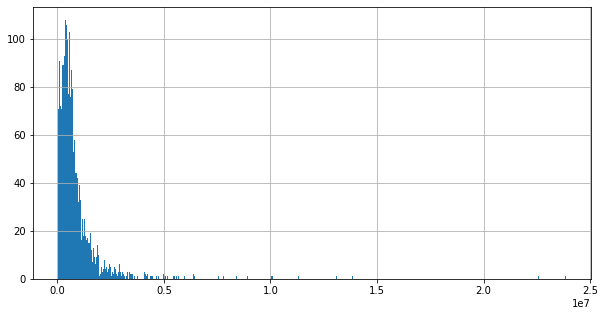

In [37]:
plt.figure(figsize=(10,5))
taxvalue_with_pool.hist(bins = 500)
plt.show()

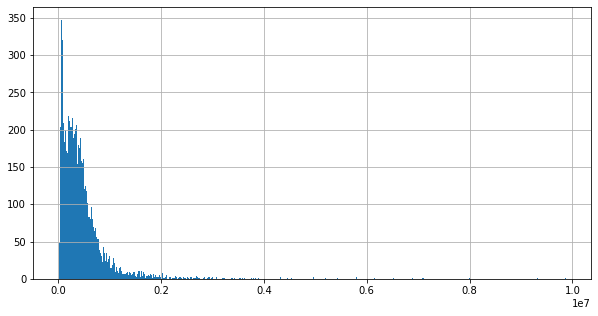

In [38]:
plt.figure(figsize=(10,5))
taxvalue_without_pool.hist(bins = 500)
plt.show()

**Equal Variance?**

In [39]:
taxvalue_with_pool.var()

1494201814857.4915

In [40]:
taxvalue_without_pool.var()

265163532323.93182

##### Run the T-test

In [41]:
t, p = stats.ttest_ind(taxvalue_with_pool, taxvalue_without_pool, equal_var = False)
t, p

(14.109242624050193, 2.5858175318036635e-43)

In [42]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null")

We reject the null hypothesis


<div class="alert alert-block alert-info">Conclusion: There is a difference in tax value between houses with pools and houses without pools</div>

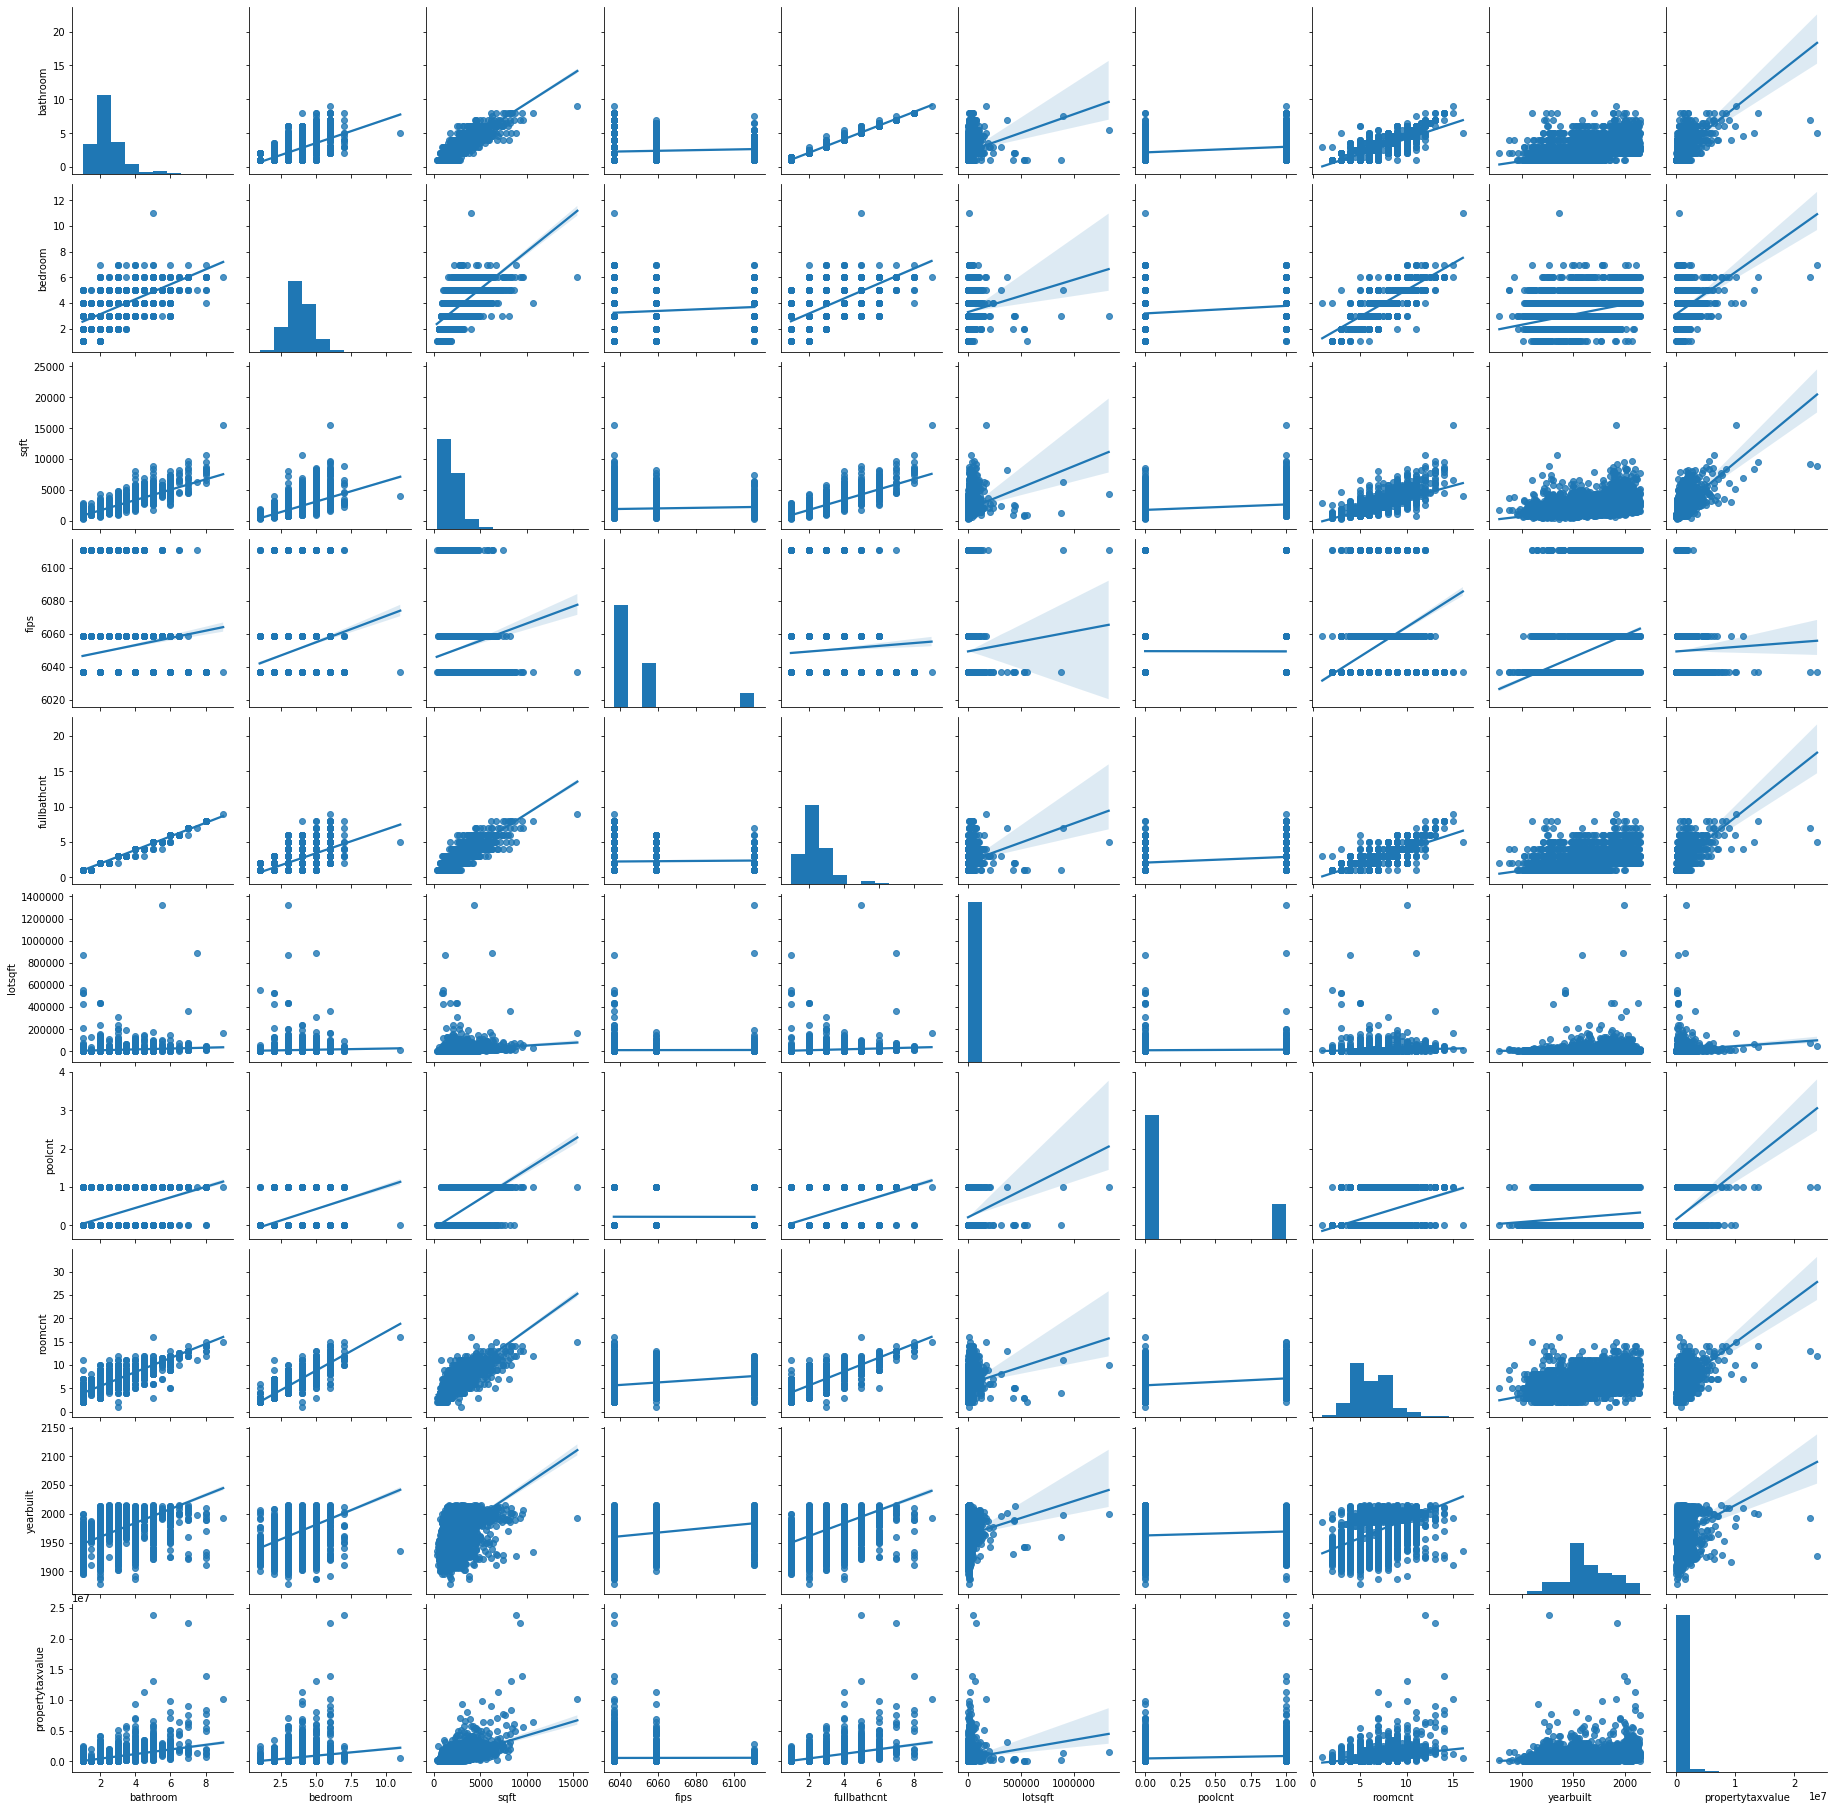

In [43]:
plot_variable_pairs(train)
plt.show()

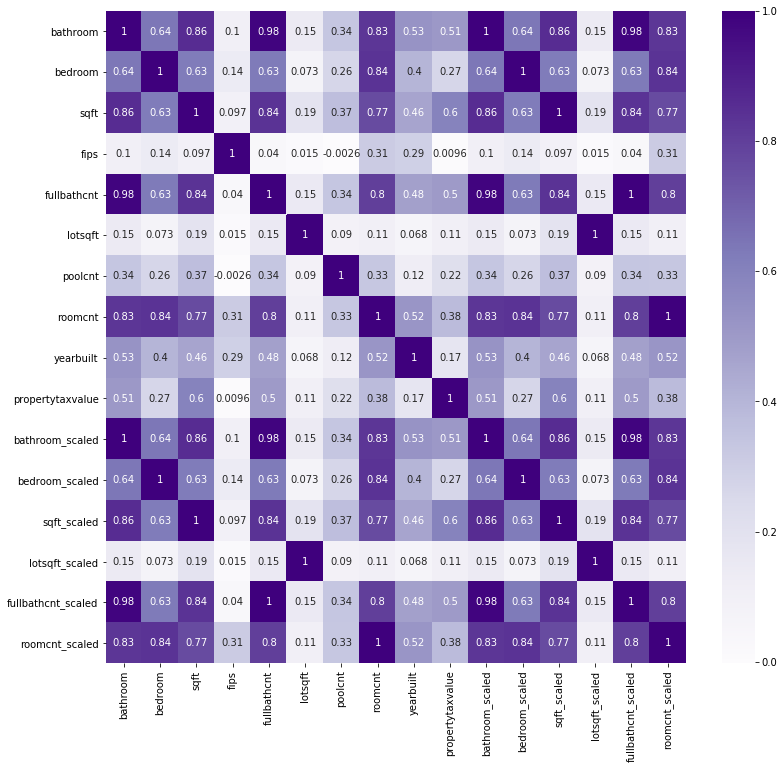

In [44]:
plt.figure(figsize=(13,12))
sns.heatmap(train.corr(), cmap='Purples', annot=True)
plt.show()

<div class="alert alert-block alert-info">Conclusion: Features that involve the bedroom, bathroom or square feet have the highest correlation to the target. This is great to know moving forward but these are just one-to-one relationships. We will run further test in feature engineering to see how the correlation results with multiple variables.</div>

## Feature Engineering

- Run mvp variables 
- Rank the features in relation to the target
- Run a SelectKBest for correlation with multiple variables
- Run a Recursive Feature Elimination for best features to model
- Select a second set of features for train section

##### MVP Features

In [45]:
X_train_mvp = train[['sqft_scaled', 'bedroom_scaled', 'bathroom_scaled']]
y_train_mvp = train[['propertytaxvalue']]

X_validate_mvp = validate[['sqft_scaled', 'bedroom_scaled', 'bathroom_scaled']]
y_validate_mvp = validate[['propertytaxvalue']]

X_test_mvp = test[['sqft_scaled', 'bedroom_scaled', 'bathroom_scaled']]
y_test_mvp = test[['propertytaxvalue']]

##### Only Scaled Features

In [46]:
X = train.drop(columns=['bathroom', 'bedroom', 'sqft', 'fullbathcnt', 'lotsqft', 'roomcnt', 'yearbuilt', 'propertytaxvalue'])
y = train[['propertytaxvalue']]


<div class="alert alert-block alert-info">Create a dataframe of only scaled columns so we can run a couple of feature engineering test </div>

##### Ranking Features

In [47]:
lm = LinearRegression()
rfe_ = RFE(lm, 1)
rfe_.fit(X, y)
ranks = rfe_.ranking_
names = X.columns.tolist()
pd.DataFrame({'features': names, 'rank': ranks}).set_index('rank')

,features
rank,
8,fips
7,poolcnt
6,bathroom_scaled
2,bedroom_scaled
1,sqft_scaled
5,lotsqft_scaled
4,fullbathcnt_scaled
3,roomcnt_scaled


<div class="alert alert-block alert-info">The top four features in descending order is 'sqft_scaled', 'bedroom_scaled', 'roomcnt_scaled' and 'fullbathcnt_scaled'</div>

##### SelectKBest Correlation

In [48]:
select_kbest(X, y, 3)

['bathroom_scaled', 'sqft_scaled', 'fullbathcnt_scaled']


<div class="alert alert-block alert-info">The features that have the highest correlation to the target is 'bathroom_scaled', 'sqft_scaled' and 'fullbathcnt_scaled'</div>

##### Recursive Feature Elimination

In [49]:
rfe(X, y, 3)

['bedroom_scaled', 'sqft_scaled', 'roomcnt_scaled']


<div class="alert alert-block alert-info">The features that modeled the best at predicting the target is 'bedroom_scaled', 'sqft_scaled' and 'roomcnt_scaled'</div>

#### Top Features for Second Model

In [78]:
X_train = train[['bedroom_scaled', 'sqft_scaled', 'bathroom_scaled', 'roomcnt_scaled']]
y_train = train[['propertytaxvalue']]

X_validate = validate[['bedroom_scaled', 'sqft_scaled', 'bathroom_scaled', 'roomcnt_scaled']]
y_validate = validate[['propertytaxvalue']]

X_test = test[['bedroom_scaled', 'sqft_scaled', 'bathroom_scaled', 'roomcnt_scaled']]
y_test = test[['propertytaxvalue']]


<div class="alert alert-block alert-info">We will use 'bedroom_scaled', 'sqft_scaled', 'bathroom_scaled' and 'roomcnt_scaled' for our second set of training data </div>

## Modeling

- Set the Baseline
- Create Linear Regression, LassoLars and Polynomial Squared models for two sets of features
- Analyze the results

##### Setting the Baseline

In [79]:
np.mean(y_train)

baseline_rmse = mean_squared_error(y_train, np.full(8922, np.mean(y_train)))**(1/2)

baseline_rmse

750570.3525956493

### Train

##### Linear Regression Model 1

In [80]:
lm_rmse = linearReg_train(X_train_mvp, y_train_mvp)

lm_rmse

590417.7693529542

##### LassoLars Model 1

In [81]:
lars_rmse = lassoLars_train(X_train_mvp, y_train_mvp)

lars_rmse

590417.8152195138

##### Polynomial Squared Model 1

In [82]:
lm_squared_rmse = poly_linearReg_train(X_train_mvp, y_train_mvp, 2)

lm_squared_rmse

559929.4082537807

##### Linear Regression Model 2

In [83]:
lm_rmse2 = linearReg_train(X_train, y_train)

lm_rmse2

589076.3486454749

##### LassoLars Model 2

In [84]:
lars_rmse2 = lassoLars_train(X_train, y_train)

lars_rmse2

589076.4443968087

##### Polynomial Squared Model 2

In [85]:
lm_squared_rmse2 = poly_linearReg_train(X_train, y_train, 2)

lm_squared_rmse2

558641.2952906246

##### Grouping the Results

In [86]:
print("Baseline, Mean: ", baseline_rmse)
print("Linear Regression Model 1: ", lm_rmse)
print("Linear Regression Model 2: ", lm_rmse2)
print("LassoLars Model 1: ", lars_rmse)
print("LassoLars Model 2: ", lars_rmse2)
print("Polynomial Squared Model 1: ", lm_squared_rmse)
print("Polynomial Squared Model 2: ", lm_squared_rmse2)

Baseline, Mean:  750570.3525956493
Linear Regression Model 1:  590417.7693529542
Linear Regression Model 2:  589076.3486454749
LassoLars Model 1:  590417.8152195138
LassoLars Model 2:  589076.4443968087
Polynomial Squared Model 1:  559929.4082537807
Polynomial Squared Model 2:  558641.2952906246


<div class="alert alert-block alert-info">At first glance, our Polynomial Squared Models performed the best. We will use move onto the validate section but keeping in mind that those functions tend to overfit the first set of data.</div>

### Validate

- Create Linear Regression, LassoLars and Polynomial Squared models with the validate datasets 
- Compare the results to the test datasets
- Select the best model

##### Linear Regression Model 1

In [87]:
lm_rmse_val = linearReg_validate(X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp)

lm_rmse_val

563466.0482839952

##### LassoLars Model 1

In [88]:
lars_rmse_val = lassoLars_validate(X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp)

lars_rmse_val

563453.8589325164

##### Polynomial Squared Model 1

In [89]:
lm_squared_rmse_val = poly_linearReg_validate(X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp, 2)

lm_squared_rmse_val

537921.8125918185

##### Linear Regression Model 2

In [90]:
lm_rmse_val2 = linearReg_validate(X_train, y_train, X_validate, y_validate)

lm_rmse_val2

561663.638493082

##### LassoLars Model 2

In [91]:
lars_rmse_val2 = lassoLars_validate(X_train, y_train, X_validate, y_validate)

lars_rmse_val2

561654.2424728198

##### Polynomial Squared Model 2

In [92]:
lm_squared_rmse_val2 = poly_linearReg_validate(X_train, y_train, X_validate, y_validate, 2)

lm_squared_rmse_val2

537026.1982534556

##### Grouping the Results

In [93]:
print("       Models       |      Train      |      Validate")
print("Baseline, Mean: ", baseline_rmse)
print("Linear Regression Model 1: ", lm_rmse, lm_rmse_val)
print("Linear Regression Model 2: ", lm_rmse2, lm_rmse_val2)
print("LassoLars Model 1: ", lars_rmse, lars_rmse_val)
print("LassoLars Model 2: ", lars_rmse2, lars_rmse_val2)
print("Polynomial Squared Model 1: ", lm_squared_rmse, lm_squared_rmse_val)
print("Polynomial Squared Model 2: ", lm_squared_rmse2, lm_squared_rmse_val2)

       Models       |      Train      |      Validate
Baseline, Mean:  750570.3525956493
Linear Regression Model 1:  590417.7693529542 563466.0482839952
Linear Regression Model 2:  589076.3486454749 561663.638493082
LassoLars Model 1:  590417.8152195138 563453.8589325164
LassoLars Model 2:  589076.4443968087 561654.2424728198
Polynomial Squared Model 1:  559929.4082537807 537921.8125918185
Polynomial Squared Model 2:  558641.2952906246 537026.1982534556


<div class="alert alert-block alert-info">Conclusion: Since the Polynomial Squared Model 2 has the best overall score and the smallest difference between Train and Validate, we will move forward with this model to Test.</div>

### Test

- Use the best model on the test dataset 
- Graph the results

In [94]:
lm_squared_rmse_test = poly_linearReg_validate(X_train, y_train, X_test, y_test, 2)

lm_squared_rmse_test

548450.2823572332

<div class="alert alert-block alert-info">Conclusion: Polynomial Squared Model 2 performed within the Train and Validate parameters while also performing better than other models.</div>

##### Prepping the Graph

In [95]:
X_rfe = rfe_.fit_transform(X_train,y_train) 
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_rfe)

lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.propertytaxvalue)

y_train['yhat_poly'] = lm_poly.predict(X_poly)
y_train['yhat_baseline'] = train.propertytaxvalue.mean()

<div class="alert alert-block alert-info"> We are creating a baseline, fitting and transforming the best model so we can create a y-hat variable for the graph</div>

##### Graphing Final Results

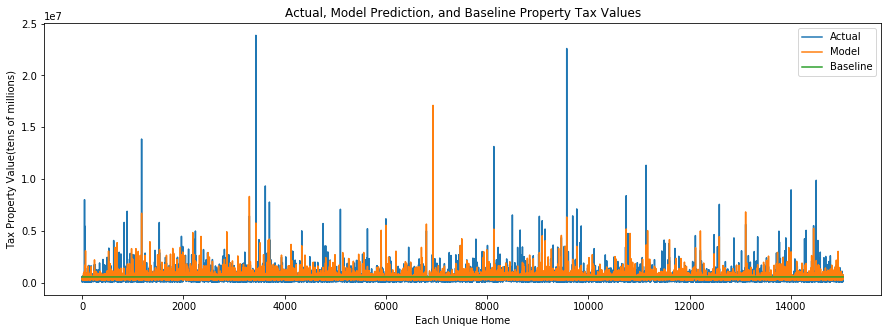

In [96]:
plt.figure(figsize=(15,5))
plt.title("Actual, Model Prediction, and Baseline Property Tax Values")
sns.lineplot(data = y_train.propertytaxvalue, label = "Actual")
sns.lineplot(data = y_train.yhat_poly, label = "Model")
sns.lineplot(data = y_train.yhat_baseline, label = "Baseline")
plt.xlabel('Each Unique Home')
plt.ylabel('Tax Property Value(tens of millions)')
plt.show()

## Conclusion

<div class="alert alert-block alert-info"> 

- Many of the original data was scraped due to a high number of null values.
- There was a high correlation between bedroom, bathroom and squarefeet to the property tax value. 
- The Polynomial Squared Model 2 out perfomed our baseline by 26.98% at predicting the target variable.

</div>

## Next Steps
If we are alloted more time:

<div class="alert alert-block alert-info">

- We can further explore the original data to see if we can fill in the null values.
- We could change the bedrooms and bathrooms into categorical to see if they would be weighted differently.
- We could further analyze the outliers and possibly remove them so we can increase performance on our model.

</div>